In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

import pandas as pd
import risk_kit as rk
import numpy as np

In [8]:
ind = rk.get_ind_returns()
er = rk.annualize_rets(ind["1996":"2000"], 12)
cov = ind["1996":"2000"].cov()
er

Food     0.116799
Beer     0.141126
Smoke    0.107830
Games    0.068212
Books    0.187286
Hshld    0.134766
Clths    0.079160
Hlth     0.246641
Chems    0.077456
Txtls   -0.042721
Cnstr    0.084076
Steel    0.115809
FabPr    0.108280
ElcEq    0.272420
Autos    0.080954
Carry    0.173904
Mines   -0.053554
Coal     0.414689
Oil      0.165377
Util     0.145903
Telcm    0.122771
Servs    0.175264
BusEq    0.271952
Paper    0.097163
Trans    0.071099
Whlsl    0.126431
Rtail    0.207247
Meals    0.067400
Fin      0.223371
Other    0.043349
dtype: float64

In [3]:
from scipy.optimize import minimize

def portfolio_return(weights, rets):
    return weights.T @ rets

def portfolio_volatility(weights, covmat):
    return (weights.T @ covmat @ weights) ** 0.5

def optimal_weights(n_points, er, cov):
    target_rets = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_ret, er, cov) for target_ret in target_rets]
    return weights

def minimize_vol(target_ret, er, cov):
    n_assets = er.shape[0]
    init_guess = np.repeat(1/n_assets, n_assets)
    bounds = ((0.0, 1.0),) * n_assets
    
    is_target_return = { 
        "type": "eq",
        "args": (er, ),
        "fun": lambda weights, er: target_ret - portfolio_return(weights, er)
    }
    full_allocated = {
        "type": "eq",
        "fun": lambda weights: np.sum(weights) - 1
    }
    
    results = minimize(portfolio_volatility, init_guess,
                      args=(cov, ), method="SLSQP",
                      options={"disp": False},
                      constraints=(is_target_return, full_allocated),
                      bounds=bounds)
    return results.x

def efficient_frontier(er, cov, n_points):
    weights = optimal_weights(n_points, er, cov)
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_volatility(w, cov) for w in weights]
    return pd.DataFrame({"Returns": rets, "Volatility": vols})

In [4]:
l = ["Games", "Fin"]
w15 = minimize_vol(0.15, er[l], cov.loc[l, l])
vol15 = portfolio_volatility(w15, cov.loc[l, l])
vol15

0.056163669406706564

In [5]:
w15        # 0.47 on asset1 and 0.52 on asset2 results on the minimun volatility for 15% return

array([0.47287631, 0.52712369])

<AxesSubplot:xlabel='Volatility', ylabel='Returns'>

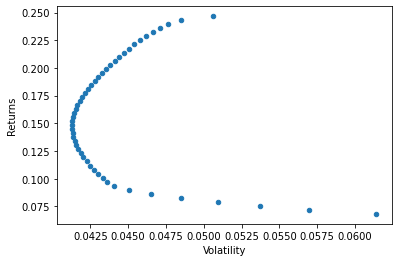

In [6]:
assets = ["Food", "Beer", "Fin", "Hlth", "Games", "Smoke"]
ef = efficient_frontier(er[assets], cov.loc[assets, assets], 50)
ef.plot.scatter(x="Volatility", y="Returns")

<AxesSubplot:xlabel='Volatility'>

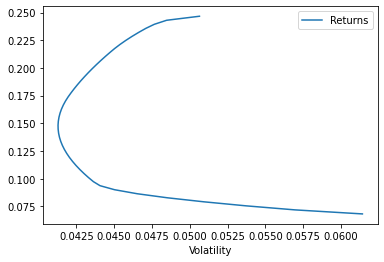

In [7]:
ef.plot.line(x="Volatility", y="Returns")

<AxesSubplot:xlabel='Volatility'>

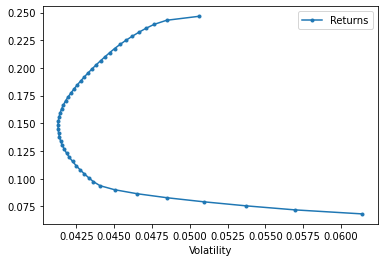

In [60]:
ef.plot.line(x="Volatility", y="Returns", style=".-")